## Purpose: create a training set of sources with labels



In [1]:
import splat
import wisps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from wisps import datasets
from scipy import stats
%matplotlib inline

In [2]:
sf0=pd.read_pickle(wisps.OUTPUT_FILES+'/selection_function.pkl.gz')
sf=pd.DataFrame.from_records(pd.DataFrame(sf0).values.flatten())

In [5]:
alldata=pd.read_hdf(wisps.LIBRARIES+'/master_dataset.h5',  key='new')
star_ids=alldata#[alldata['class_star'] !=0]
stars=wisps.Annotator.reformat_table(star_ids).reset_index(drop=True)


In [6]:
len(alldata[(alldata.snr1< 3.) &(alldata.grism_id.str.lower().str.startswith('par'))])

135727

In [7]:
#I should probably add a list of galaxies
#let's start with from Zanella et al. 2016

In [8]:
stars.grism_id=stars.grism_id.apply(lambda x: str(x).lower())

In [9]:
trash_names=trash=pd.read_pickle(wisps.OUTPUT_FILES+'/trash.pkl.gz').grism_id

In [10]:
trash=stars[stars.grism_id.isin(trash_names)]

In [11]:
trash['label']=0.

In [12]:
spex=(datasets['spex']).rename(columns={'spt':'spt_tupl'})

In [13]:
spex['grism_id']=spex.data_file

In [14]:
man=(datasets['manjavacas']).rename(columns={'f':'f_test'})
schn=(datasets['schneider']).rename(columns={'f':'f_test'})

In [15]:
spex['spt']=np.vstack(spex.spt_tupl.values)[:,0]
spex['spt_unc']=np.vstack(spex.spt_tupl.values)[:,1]

In [16]:
spex['spt']=spex.spt.apply(wisps.make_spt_number)
man['spt']=man.spt.apply(wisps.make_spt_number)
schn['spt']=schn.spt.apply(wisps.make_spt_number)
trash['spt']=trash.spt.apply(wisps.make_spt_number)
spex['name']=spex['grism_id']

In [17]:
features =np.concatenate([wisps.INDEX_NAMES, ['spex_chi', 'snr2', 'snr1', 'snr3','snr4',
       'line_chi', 'label', 'f_test', 'spt', 'snr1', 'dof']])

In [18]:

def f_test_fx(x, df1, df2):
    return stats.f.cdf(x, df1, df2)

man['x']=man.spex_chi/man.line_chi
schn['x']=schn.spex_chi/schn.line_chi

man['f_test']=f_test_fx(man.x, man.dof-2, man.dof-2 )
schn['f_test']=f_test_fx(schn.x, schn.dof-2, schn.dof-2 )
spex['f_test']=f_test_fx(spex.spex_chi/spex.line_chi, spex.dof-2, spex.dof-2 )
sf['f_test']=f_test_fx(sf.spex_chi/sf.line_chi, sf.dof-2, sf.dof-2 )
trash['f_test']=f_test_fx(trash.spex_chi/trash.line_chi,trash.nG141-2, trash.nG141-2 )
trash['dof']=trash.nG141

In [19]:
trash['name']=trash.grism_id
sf['name']=['spc {}'+str(i) for i in sf.index]

In [20]:
feats=[x for x in features if x not in ['name']]

In [21]:
#def add_binary_label(row, label):
#    row

In [22]:
trash['label']='trash'
spex['label']='spex'
schn['label']='schn'
sf['label']='sf'
man['label']='man'

In [23]:
spex=spex.iloc[(spex[wisps.INDEX_NAMES]).dropna().index]
man=man.iloc[(man[wisps.INDEX_NAMES]).dropna().index]
schn=schn.iloc[(schn[wisps.INDEX_NAMES]).dropna().index]

In [24]:
spex=wisps.Annotator.reformat_table(spex)
trash=wisps.Annotator.reformat_table(trash)
schn=wisps.Annotator.reformat_table(schn)
man=wisps.Annotator.reformat_table(man)
sf=wisps.Annotator.reformat_table(sf)

In [25]:
sf['spt']=np.vstack(sf.spt_new.values)[:,0]

In [26]:
training_set=pd.concat( [ spex[features], trash[features], man[features], schn[features], sf[features]]).reset_index(drop=True)

In [27]:
training_set=(training_set[features]).dropna(how='all').reset_index(drop=True)

In [28]:
final_set=training_set

In [29]:
#final_set=pd.concat([label0, label1]).reset_index(drop=True)

In [30]:
#final_set=final_set.reset_index(drop=True).applymap(float)

In [31]:
final_set = final_set.loc[:,~final_set.columns.duplicated()]

In [32]:
final_set.to_pickle(wisps.LIBRARIES+'/training_set.pkl', protocol=2)
#alldata.to_pickle(wisps.LIBRARIES+'/master_dataset.pkl',  protocol=2)

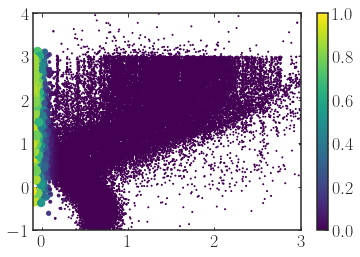

In [33]:
plt.scatter(np.log10(final_set.line_chi/final_set.spex_chi), 
            final_set['snr1'].apply(np.log10),s=100*(0.01+final_set.f_test),
            c=final_set.f_test, cmap='viridis')
plt.xlim([-0.1, 3])
plt.ylim([-1, 4.])
plt.colorbar()